In [1]:
import os
import json
import numpy as np
import re
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
cfg = {
    
    'train_path': '/kaggle/input/contract-nli-dataset/train.json',
    'test_path': '/kaggle/input/contract-nli-dataset/test.json',
}

In [3]:
def load_data(path: str) -> dict:
    with open(path, 'r') as f:
        data = json.load(f)
    return data

In [4]:
def get_labels() -> dict:
    return {'NotMentioned': 0, 'Entailment': 1, 'Contradiction': 2}

In [5]:
def get_hypothesis(data: dict) -> dict:
    return {key: clean_str(value['hypothesis']) for key, value in data['labels'].items()}

In [6]:
def clean_str(text: str) -> str:
    text = re.sub(r'\\[trn]', ' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    return text.strip().lower()


In [7]:
def clean_data(data: dict) -> None:
    for document in data['documents']:
        document['text'] = clean_str(document['text'])


In [8]:
def prepare_tfidf_vectorizer(train_data: dict) -> TfidfVectorizer:
    all_text = [doc["text"] for doc in train_data["documents"]]
    tfidf = TfidfVectorizer()
    tfidf.fit(all_text)
    return tfidf


In [9]:
def get_Ypred_Ytrue(data: dict, tfidf: TfidfVectorizer, hypothesis: dict) -> (list, list):
    Y_pred, Y_true = [], []
    hypothesis_vecs = {key: tfidf.transform([val]) for key, val in hypothesis.items()}

    for doc in tqdm(data["documents"], desc="Processing Contracts"):
        doc_text = doc["text"]
        doc_Y_pred, doc_Y_true = [], []

        for key, val in hypothesis.items():
            choice = doc["annotation_sets"][0]["annotations"][key]["choice"]
            if choice == "NotMentioned":
                continue

            relevant_spans = doc["annotation_sets"][0]["annotations"][key]["spans"]

            for idx, (start, end) in enumerate(doc["spans"]):
                span_text = doc_text[start:end]
                span_vector = tfidf.transform([span_text])
                cosine_sim = cosine_similarity(span_vector, hypothesis_vecs[key])[0][0]

                doc_Y_pred.append(cosine_sim)
                doc_Y_true.append(1 if idx in relevant_spans else 0)

        Y_pred.append(doc_Y_pred)
        Y_true.append(doc_Y_true)

    return Y_pred, Y_true

In [10]:
def precision_at_80_recall(ypred, ytrue):
    precision, recall, thresholds = precision_recall_curve(ytrue, ypred)
    idx = (abs(recall - 0.8)).argmin()
    return precision[idx]


In [11]:
def mean_average_precision(Y_pred, Y_true):
    average_prec_scores = [average_precision_score(Y_true[i], Y_pred[i]) for i in range(len(Y_true))]
    return np.mean(average_prec_scores)


In [12]:
def evaluate_model(Y_pred, Y_true):
    all_y_pred = np.concatenate(Y_pred)
    all_y_true = np.concatenate(Y_true)

    prec_arr = [precision_at_80_recall(Y_pred[i], Y_true[i]) for i in range(len(Y_true))]
    precision_at_80 = np.mean(prec_arr)

    mean_avg_precision = mean_average_precision(Y_pred, Y_true)

    accuracy = accuracy_score(all_y_true, (all_y_pred > 0.5).astype(int))

    report = classification_report(all_y_true, (all_y_pred > 0.5).astype(int), target_names=['Not Relevant', 'Relevant'])

    cm = confusion_matrix(all_y_true, (all_y_pred > 0.5).astype(int))

    print("\n--- Evaluation Metrics ---")
    print(f"Precision @ 80% Recall: {precision_at_80:.4f}")
    print(f"Mean Average Precision: {mean_avg_precision:.4f}")
    print(f"Accuracy: {accuracy:.4f}\n")
    print("--- Classification Report ---\n", report)

    plt.figure(figsize=(8, 6))
    
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
        xticklabels=['Not Relevant', 'Relevant'],
        yticklabels=['Not Relevant', 'Relevant'],
        annot_kws={"size": 14, "weight": "bold", "color": "red"}
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


In [13]:
train_data = load_data(cfg['train_path'])
test_data = load_data(cfg['test_path'])
clean_data(train_data)
clean_data(test_data)

In [14]:
hypothesis = get_hypothesis(train_data)
tfidf = prepare_tfidf_vectorizer(train_data)

In [15]:
Y_pred_test, Y_true_test = get_Ypred_Ytrue(test_data, tfidf, hypothesis)

Processing Contracts: 100%|██████████| 123/123 [02:36<00:00,  1.27s/it]



--- Evaluation Metrics ---
Precision @ 80% Recall: 0.0597
Mean Average Precision: 0.1536
Accuracy: 0.9759

--- Classification Report ---
               precision    recall  f1-score   support

Not Relevant       0.98      1.00      0.99     98484
    Relevant       0.26      0.01      0.01      2404

    accuracy                           0.98    100888
   macro avg       0.62      0.50      0.50    100888
weighted avg       0.96      0.98      0.96    100888



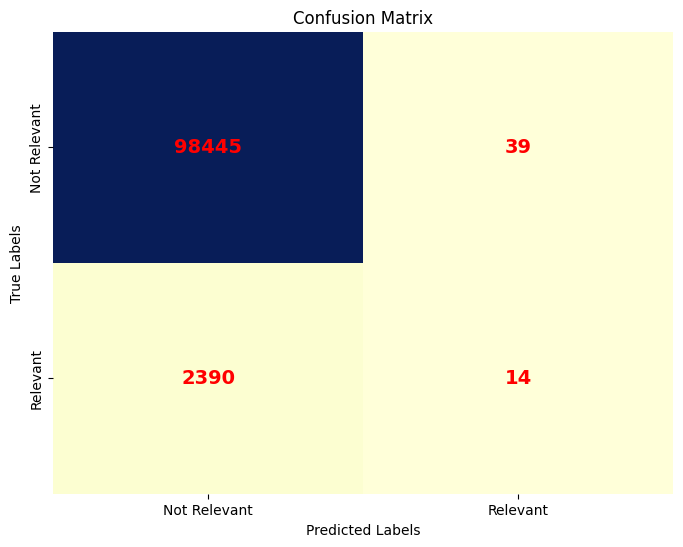

In [16]:
evaluate_model(Y_pred_test, Y_true_test)